In [1]:
import argparse
import subprocess, os
from process_data import *
import random
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from data.dataset import create_datasets
from Generator.Generator import generator
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

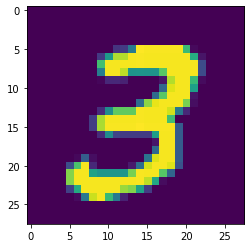

In [2]:
img=train_dataset[7]
plt.imshow(img[0].view(28,28))
plt.show()

In [3]:
#VAE


class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()



In [4]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [5]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [6]:


def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))



In [7]:


for epoch in range(1, 51):
    train(epoch)
    test()



/u/piedboef/Documents/VAETI/venv/lib/python3.10/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 542.158047
Train Epoch: 1 [10000/60000 (17%)]	Loss: 187.161035
Train Epoch: 1 [20000/60000 (33%)]	Loss: 170.555820
Train Epoch: 1 [30000/60000 (50%)]	Loss: 164.830273
Train Epoch: 1 [40000/60000 (67%)]	Loss: 167.527109
Train Epoch: 1 [50000/60000 (83%)]	Loss: 162.605088
====> Epoch: 1 Average loss: 177.9354
====> Test set loss: 161.7420
Train Epoch: 2 [0/60000 (0%)]	Loss: 152.200293
Train Epoch: 2 [10000/60000 (17%)]	Loss: 158.943535
Train Epoch: 2 [20000/60000 (33%)]	Loss: 160.054756
Train Epoch: 2 [30000/60000 (50%)]	Loss: 157.333984
Train Epoch: 2 [40000/60000 (67%)]	Loss: 154.768789
Train Epoch: 2 [50000/60000 (83%)]	Loss: 158.558145
====> Epoch: 2 Average loss: 157.4288
====> Test set loss: 154.4403
Train Epoch: 3 [0/60000 (0%)]	Loss: 153.457998
Train Epoch: 3 [10000/60000 (17%)]	Loss: 156.636973
Train Epoch: 3 [20000/60000 (33%)]	Loss: 162.320879
Train Epoch: 3 [30000/60000 (50%)]	Loss: 142.909971
Train Epoch: 3 [40000/60000 (67%)]	Loss: 147.52

Train Epoch: 22 [50000/60000 (83%)]	Loss: 136.586914
====> Epoch: 22 Average loss: 138.0841
====> Test set loss: 139.6608
Train Epoch: 23 [0/60000 (0%)]	Loss: 133.821973
Train Epoch: 23 [10000/60000 (17%)]	Loss: 136.530869
Train Epoch: 23 [20000/60000 (33%)]	Loss: 132.201240
Train Epoch: 23 [30000/60000 (50%)]	Loss: 140.735059
Train Epoch: 23 [40000/60000 (67%)]	Loss: 151.719990
Train Epoch: 23 [50000/60000 (83%)]	Loss: 143.154502
====> Epoch: 23 Average loss: 137.9407
====> Test set loss: 139.5661
Train Epoch: 24 [0/60000 (0%)]	Loss: 134.475215
Train Epoch: 24 [10000/60000 (17%)]	Loss: 133.180410
Train Epoch: 24 [20000/60000 (33%)]	Loss: 139.737139
Train Epoch: 24 [30000/60000 (50%)]	Loss: 147.200332
Train Epoch: 24 [40000/60000 (67%)]	Loss: 131.547207
Train Epoch: 24 [50000/60000 (83%)]	Loss: 139.145352
====> Epoch: 24 Average loss: 137.7819
====> Test set loss: 139.4800
Train Epoch: 25 [0/60000 (0%)]	Loss: 131.848926
Train Epoch: 25 [10000/60000 (17%)]	Loss: 132.792510
Train Epoch: 

Train Epoch: 44 [20000/60000 (33%)]	Loss: 133.695264
Train Epoch: 44 [30000/60000 (50%)]	Loss: 129.313770
Train Epoch: 44 [40000/60000 (67%)]	Loss: 133.089482
Train Epoch: 44 [50000/60000 (83%)]	Loss: 137.078252
====> Epoch: 44 Average loss: 135.2893
====> Test set loss: 138.0811
Train Epoch: 45 [0/60000 (0%)]	Loss: 128.901172
Train Epoch: 45 [10000/60000 (17%)]	Loss: 136.373105
Train Epoch: 45 [20000/60000 (33%)]	Loss: 129.133789
Train Epoch: 45 [30000/60000 (50%)]	Loss: 144.591328
Train Epoch: 45 [40000/60000 (67%)]	Loss: 139.430176
Train Epoch: 45 [50000/60000 (83%)]	Loss: 133.093926
====> Epoch: 45 Average loss: 135.0420
====> Test set loss: 137.8824
Train Epoch: 46 [0/60000 (0%)]	Loss: 137.487998
Train Epoch: 46 [10000/60000 (17%)]	Loss: 133.326436
Train Epoch: 46 [20000/60000 (33%)]	Loss: 136.032314
Train Epoch: 46 [30000/60000 (50%)]	Loss: 134.350898
Train Epoch: 46 [40000/60000 (67%)]	Loss: 133.853174
Train Epoch: 46 [50000/60000 (83%)]	Loss: 127.153047
====> Epoch: 46 Average 